In [97]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from xgboost import plot_importance

In [66]:
df_original = pd.read_csv("HR_capstone.csv")
df_original.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,Department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


# EDA and Data Cleaning

In [67]:
df_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     14999 non-null  float64
 1   last_evaluation        14999 non-null  float64
 2   number_project         14999 non-null  int64  
 3   average_montly_hours   14999 non-null  int64  
 4   time_spend_company     14999 non-null  int64  
 5   Work_accident          14999 non-null  int64  
 6   left                   14999 non-null  int64  
 7   promotion_last_5years  14999 non-null  int64  
 8   Department             14999 non-null  object 
 9   salary                 14999 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


In [68]:
# Summary Statistics
df_original.describe()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000
mean,0.612834,0.716102,3.803054,201.050337,3.498233,0.144610,0.238083,0.021268
std,0.248631,0.171169,1.232592,49.943099,1.460136,0.351719,0.425924,0.144281
min,0.090000,0.360000,2.000000,96.000000,2.000000,0.000000,0.000000,0.000000
25%,0.440000,0.560000,3.000000,156.000000,3.000000,0.000000,0.000000,0.000000
50%,0.640000,0.720000,4.000000,200.000000,3.000000,0.000000,0.000000,0.000000
75%,0.820000,0.870000,5.000000,245.000000,4.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,7.000000,310.000000,10.000000,1.000000,1.000000,1.000000


Half of the data (50 percentile) falls bellow a satisfaction level of 64%

In [69]:
# Renaming columns
renamed = {'Work_accident': 'work_accident', 'left': 'left_company', 'Department': 'department', 'average_montly_hours': 'average_monthly_hours'}
df1 = df_original.rename(columns = renamed)
df1.columns

Index(['satisfaction_level', 'last_evaluation', 'number_project',
       'average_monthly_hours', 'time_spend_company', 'work_accident',
       'left_company', 'promotion_last_5years', 'department', 'salary'],
      dtype='object')

In [70]:
# Checking for missing values
df1.isna().sum()

satisfaction_level       0
last_evaluation          0
number_project           0
average_monthly_hours    0
time_spend_company       0
work_accident            0
left_company             0
promotion_last_5years    0
department               0
salary                   0
dtype: int64

In [71]:
# Checking for duplicates
df1.duplicated().sum()

3008

In [72]:
# Dropping duplicates
df2 = df1.drop_duplicates()
df2.duplicated().sum()

0

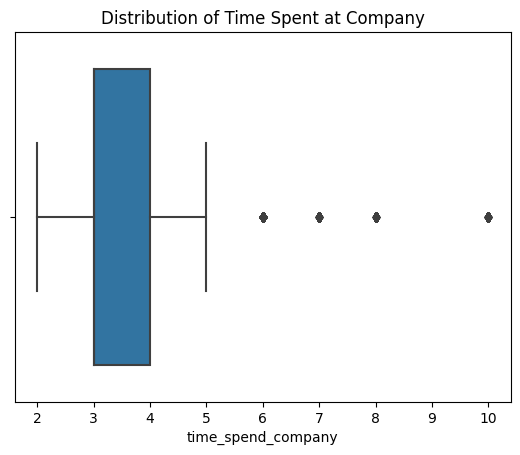

In [73]:
# Checking for Outliers
g = sns.boxplot(data=df2,
            x='time_spend_company',
            );
g.set_title('Distribution of Time Spent at Company');


In [74]:
mask = (df2['time_spend_company'] > 5) | (df2['time_spend_company'] < 2)
df2.loc[mask].shape

(824, 10)

Outliers might skew predictive results but in this case a boosted classification tree can adapt to them.

In [75]:
# Number of people who left vs Stayed
print(df2['left_company'].value_counts(normalize = True) * 100)

0    83.39588
1    16.60412
Name: left_company, dtype: float64


83% of employees in the dataset have stayed in the company, the dataset is unblanced but maneagable.

# Visualizations

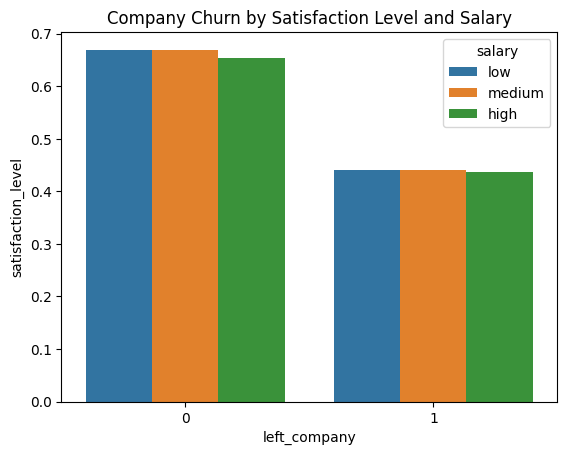

In [76]:

sns.barplot(data = df2, x = 'left_company', y = 'satisfaction_level', hue = 'salary', errorbar = None)
plt.title('Company Churn by Satisfaction Level and Salary')
plt.show()

The employees who stayed have a high satisfaction rate on average

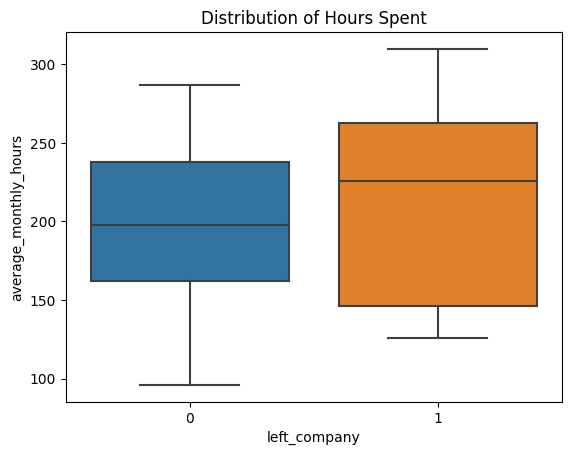

In [77]:

g = sns.boxplot(data=df2,
            x='left_company',
            y = 'average_monthly_hours'
            );
g.set_title('Distribution of Hours Spent');

Employees that have left have worked more hours on average.

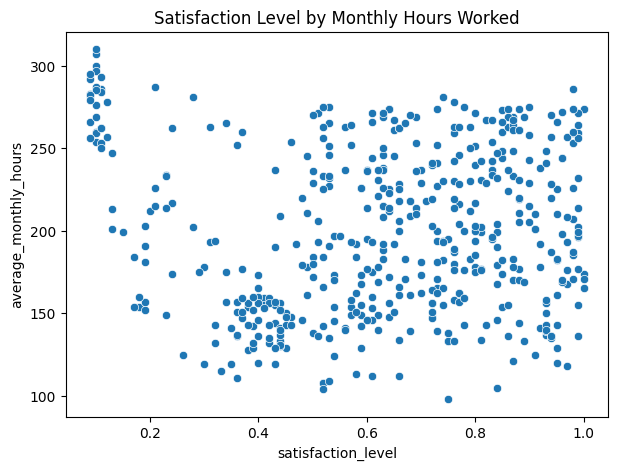

In [78]:
sampled_data = df2.sample(n=500, replace=True, random_state=42)
plt.figure(figsize = (7,5))
plt.title('Satisfaction Level by Monthly Hours Worked')
sns.scatterplot(data = sampled_data, x = 'satisfaction_level', y = 'average_monthly_hours' )
plt.show()

We can see to the upper left of the graph that employees that have a small satisfaction rate have worked a greater number of monthly hours. One way to keep employee retention would be to balance their work-life with an appropiate number of work hours.

<ipython-input-79-ad251ff530b6>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df2.corr()


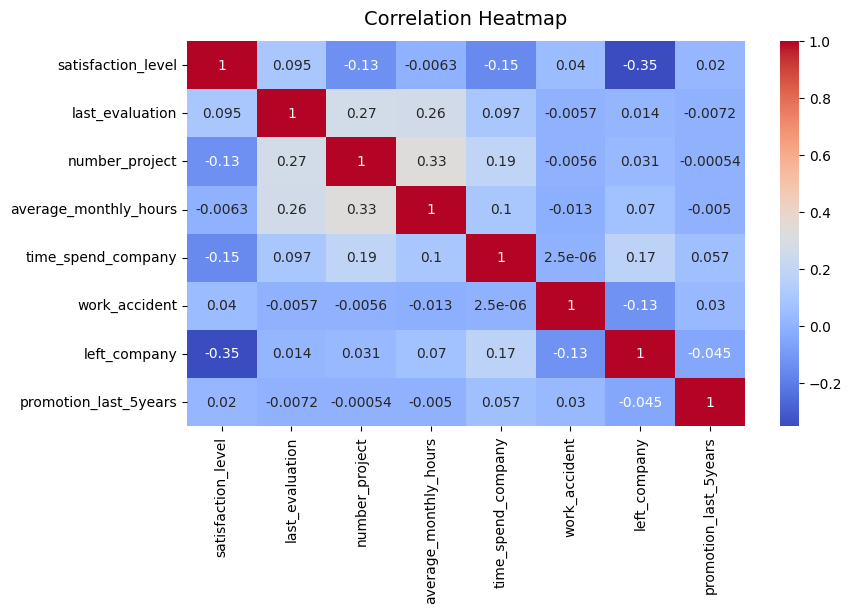

In [79]:
plt.figure(figsize=(9, 5))
corr_matrix = df2.corr()
heatmap = sns.heatmap(corr_matrix, annot=True, cmap = 'coolwarm')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':14}, pad=12);
plt.show()

The is no strong multicollinarity among the predictors

In [80]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11991 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     11991 non-null  float64
 1   last_evaluation        11991 non-null  float64
 2   number_project         11991 non-null  int64  
 3   average_monthly_hours  11991 non-null  int64  
 4   time_spend_company     11991 non-null  int64  
 5   work_accident          11991 non-null  int64  
 6   left_company           11991 non-null  int64  
 7   promotion_last_5years  11991 non-null  int64  
 8   department             11991 non-null  object 
 9   salary                 11991 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 1.0+ MB


In [81]:
# Feature engineering
x = df2[['satisfaction_level', 'average_monthly_hours', 'time_spend_company', 'promotion_last_5years', 'department', 'salary']].copy()
y = df2['left_company'].copy()

In [82]:
# Variable encoding
x_dummies = pd.get_dummies(x, columns = ['department', 'salary'], drop_first=True)

In [83]:
# Split test and training data
X_train, X_test, y_train, y_test = train_test_split(x_dummies, y, test_size=0.25,
                                                    stratify=y, random_state=42)

In [84]:
# Hyperparameter grid
cv_params = {'max_depth': [4,5,6,7,8],
             'min_child_weight': [1,2,3,4,5],
             'learning_rate': [0.1, 0.2, 0.3],
             'n_estimators': [75, 100, 125]
             }

In [85]:
xgb = XGBClassifier(objective='binary:logistic', random_state=0)

In [86]:
scoring = {'accuracy', 'precision', 'recall', 'f1'}

xgb_cv = GridSearchCV(xgb, cv_params, scoring=scoring, cv=5, refit='f1')

In [87]:
xgb_cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=0, ...),
             param_grid={'learning_rate': [0.1, 0.2, 0.3],
                         'max_depth': [4, 5, 6, 7, 8],
                         'min_child_weight': [1, 2, 3, 4, 5],
                         'n_estimators': [75, 100, 125]},
             refit='f1', scoring={'accuracy', 'f1', 'precision', 'recall'})

In [88]:
# Confusion matrix
xgb_cv_preds = xgb_cv.predict(X_test)

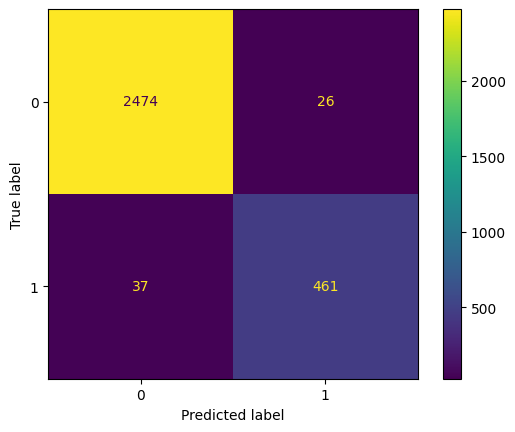

In [94]:
cm = confusion_matrix(y_test, xgb_cv_preds, labels=xgb_cv.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                display_labels=xgb_cv.classes_)

disp.plot()
plt.show()

The model shows a great prediction rate with only 26 false positives and 37 false negatives

In [95]:
print (classification_report (y_test, xgb_cv_preds))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2500
           1       0.95      0.93      0.94       498

    accuracy                           0.98      2998
   macro avg       0.97      0.96      0.96      2998
weighted avg       0.98      0.98      0.98      2998



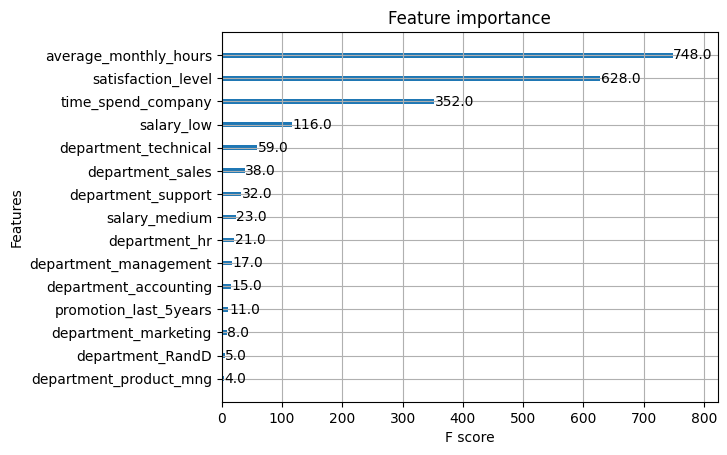

In [98]:
# Feature importance
plot_importance(xgb_cv.best_estimator_);

# In Conclusion
The most important predictor in determining employee retention contributes to the number of hours the employee works per month. We saw in the scatterplot that the more hours in overtime an employee does the less job satisfaction he or she suffers. Other noteworthy predictors are the time spent at the company overall and low salaries that contribute to employee dissatisfaction. By reducing mandatory overtime hours the company can increase employee morale and retention.